# Softmax classifier

Softmax classifier is the binary Logistic Regression classifier's generalization to multiple classes. Unlike the SVM which treats the outputs $f(x_i,W)$ as (uncalibrated and possibly difficult to interpret) scores for each class, the Softmax classifier gives a slightly more intuitive output (normalized class probabilities) and also has a probabilistic interpretation that we will describe shortly. In the Softmax classifier, the function mapping $f(x_i;W)=Wx_i$ stays unchanged, but we now interpret these scores as the unnormalized log probabilities for each class and replace the hinge loss with **a cross-entropy loss** that has the form:
$$\displaystyle L_i=−\log\left(\dfrac{e^{f_{y_i}}}{\sum_j e^{f_j}}\right) \text{ or equivalently } L_i=−f_{y_i}+\log\sum_j e^{f_j}
$$

where we are using the notation $f_j$ to mean the $j$-th element of the vector of class scores $f$. As before, the full loss for the dataset is the mean of $L_i$ over all training examples together with a regularization term $R(W)$. The function $\displaystyle f_j(z)=\dfrac{e^{z_j}}{\sum_k e^{z_k}}$ is called the **softmax function**: It takes a vector of arbitrary real-valued scores (in $z$) and squashes it to a vector of values between zero and one that sum to one. The full cross-entropy loss that involves the softmax function might look scary if you’re seeing it for the first time but it is relatively easy to motivate.

**Information theory view.** The cross-entropy between a “true” distribution p and an estimated distribution q is defined as:
$$ H(p,q) = -\sum_{x}p(x)\log q(x) $$

The Softmax classifier is hence minimizing the cross-entropy between the estimated class probabilities ($q=e^{f_{y_i}}\big/\sum_j e^{f_j}$ as seen above) and the “true” distribution, which in this interpretation is the distribution where all probability mass is on the correct class (i.e. p=[0,…1,…,0] contains a single 1 at the yi -th position.).

# Softmax exercise

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cviuh.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cviuh/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cviuh/classifiers/softmax.py`.


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cviuh/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cviuh.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.333075
sanity check: 2.302585


**Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Answer:}$ In the data preprocessing, **X_dev** is normalized (*mean* ≈ 0, *std* ≈ 1). So, the multiplication between **X_dev** and **W** will result in a matrix with values (*val*) relatively close to each other. With the number of classes $C=10$, we'll get: $\frac{e^{val}}{C * e^{val}} = \frac{e^{val}}{10 * e^{val}} ≈ 0.1$ [Denominator values are close to each other, so we can directly multiply by $C$, instead of summing them] (for every single **X_dev** sample, which will be divided by N, so, the final result will be also close to **0.1**). And by applying the softmax loss function, we'll get: **-log(0.1)**.

In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cviuh.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.502896 analytic: -0.502896, relative error: 5.192509e-08
numerical: -1.875763 analytic: -1.875763, relative error: 9.118893e-09
numerical: -0.278740 analytic: -0.278740, relative error: 4.283998e-08
numerical: -0.656547 analytic: -0.656547, relative error: 1.053188e-07
numerical: 0.148994 analytic: 0.148994, relative error: 1.251313e-07
numerical: -1.279404 analytic: -1.279404, relative error: 1.018570e-09
numerical: -1.211796 analytic: -1.211797, relative error: 1.706205e-08
numerical: 0.270900 analytic: 0.270900, relative error: 3.357570e-08
numerical: -0.032203 analytic: -0.032203, relative error: 8.226566e-07
numerical: 2.764587 analytic: 2.764587, relative error: 5.247870e-09
numerical: 2.042773 analytic: 2.042773, relative error: 9.345530e-09
numerical: 1.164686 analytic: 1.164686, relative error: 6.373273e-08
numerical: -0.376896 analytic: -0.376896, relative error: 5.625699e-08
numerical: 2.895750 analytic: 2.895750, relative error: 2.043440e-08
numerical: 1.83125

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cviuh.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.333075e+00 computed in 0.110705s
vectorized loss: 2.333075e+00 computed in 0.009974s
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cviuh.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-6] # Modified
regularization_strengths = [5e3] # Modified

for lr in learning_rates:
  for rs in regularization_strengths:
    softmax = Softmax()
    loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=rs,
                          num_iters=1500, verbose=False)

    y_train_pred = softmax.predict(X_train)
    training_accuracy = np.mean(y_train == y_train_pred)

    y_val_pred = softmax.predict(X_val)
    validation_accuracy = np.mean(y_val == y_val_pred)

    results[(lr, rs)] = (training_accuracy, validation_accuracy)

    if validation_accuracy > best_val:
      best_val = validation_accuracy
      best_softmax = softmax
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-06 reg 5.000000e+03 train accuracy: 0.361776 val accuracy: 0.370000
best validation accuracy achieved during cross-validation: 0.370000


In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.352000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Answer:}$ No, it is not possible to add a new datapoint to a training set that would leave the “new” SVM loss unchanged.

$\color{blue}{\textit Explanation:}$ The new loss formula, as defined in the question, will be:

$\displaystyle \sum_{i=0}^{N}-log\left(\frac{e^{y_{i, correct}}}{\sum_{j=0}^{C}e^{y_{i, j}}}\right)$ , with *N: Size of the training set* and *C: Number of classes*.

To leave the SVM loss unchanged, the new datapoint must have a null loss, therefore, the inner value of the log function have to be equals to 1 (so, **log(1) = 0**). And the latter is not possible to achieve, because the fraction (inside the log function) result value is bounded by 0 and 1 (strictly, in both sides).

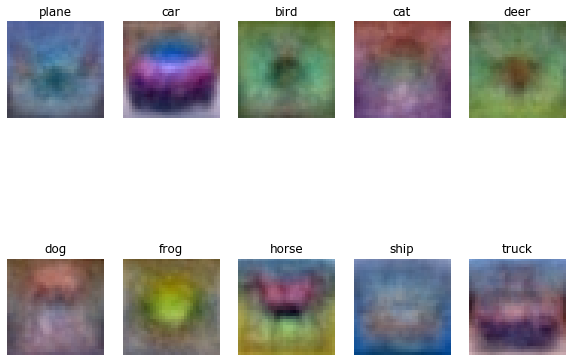

In [8]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])